In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [85]:
plt.style.use('ggplot')
sns.set_palette('viridis')

df = pd.read_csv('shopping_trends.csv')
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


In [86]:
rfm = df.groupby('Customer ID').agg({
    'Purchase Amount (USD)': lambda x: x.sum(),
    'Customer ID': lambda x: len(x),
    'Previous Purchases': 'max'
}).rename(columns={
    'Purchase Amount (USD)': 'Amount',
    'Customer ID': 'Frequency',
    'Previous Purchases': 'Recency'
}).reset_index()
rfm.head()

,Customer ID,Amount,Frequency,Recency
0,1,53,1,14
1,2,64,1,2
2,3,73,1,23
3,4,90,1,49
4,5,49,1,31


In [87]:
# Invertimos los valores de "Recency"
rfm['Recency'] = rfm['Recency'].max() - rfm['Recency']
rfm.head()

,Customer ID,Amount,Frequency,Recency
0,1,53,1,36
1,2,64,1,48
2,3,73,1,27
3,4,90,1,1
4,5,49,1,19


In [88]:
# Normalizamos
aux_log = rfm[['Recency', 'Frequency', 'Amount']].apply(np.log1p)
scaler = StandardScaler()
scaled = scaler.fit_transform(aux_log)

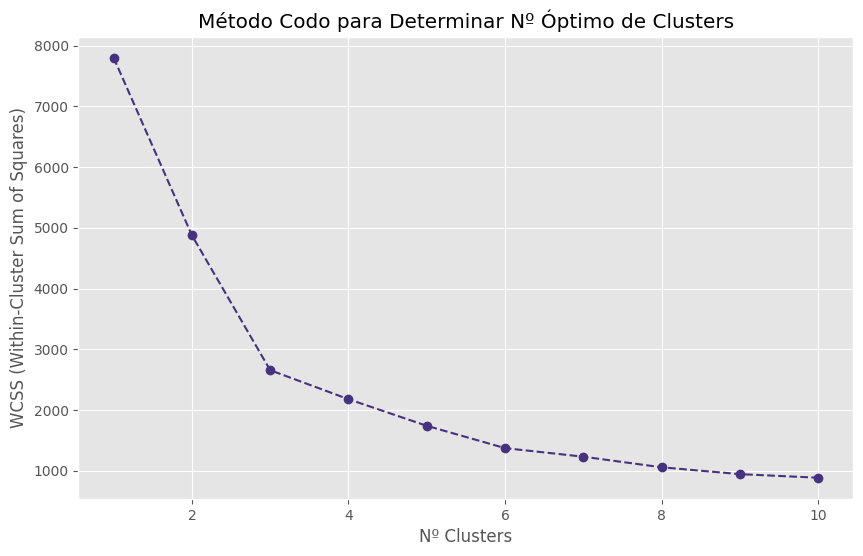

In [91]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Método Codo para Determinar Nº Óptimo de Clusters')
plt.xlabel('Nº Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

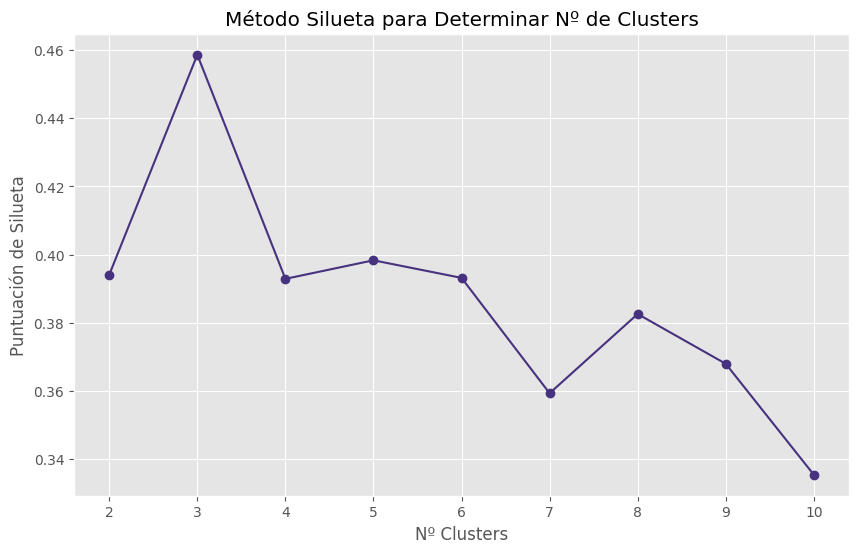

In [90]:
# Método de la silueta
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled)
    silhouette_scores.append(silhouette_score(scaled, kmeans.labels_))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Método Silueta para Determinar Nº de Clusters')
plt.xlabel('Nº Clusters')
plt.ylabel('Puntuación de Silueta')
plt.grid(True)
plt.show()

In [92]:
# Debido al pico de puntuación con el número de 3 cluster, lo elijo
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(scaled)

rfm['Cluster'] = kmeans.labels_

stats = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'min', 'max'],
    'Frequency': ['mean', 'median', 'min', 'max'],
    'Amount': ['mean', 'median', 'min', 'max'],
    'Customer ID': 'count'
}).rename(columns={'Customer ID': 'Count'})

print("Estadísticas:")
print(stats)

Estadísticas:
           Recency                Frequency                    Amount         \
              mean median min max      mean median min max       mean median   
Cluster                                                                        
0        29.810769   30.0   9  49       1.0    1.0   1   1  75.339487   76.0   
1        27.755134   28.0   4  49       1.0    1.0   1   1  33.590837   33.0   
2         4.181287    4.0   0  11       1.0    1.0   1   1  63.805556   64.0   

                 Count  
        min  max count  
Cluster                 
0        49  100  1950  
1        20   50  1266  
2        20  100   684  


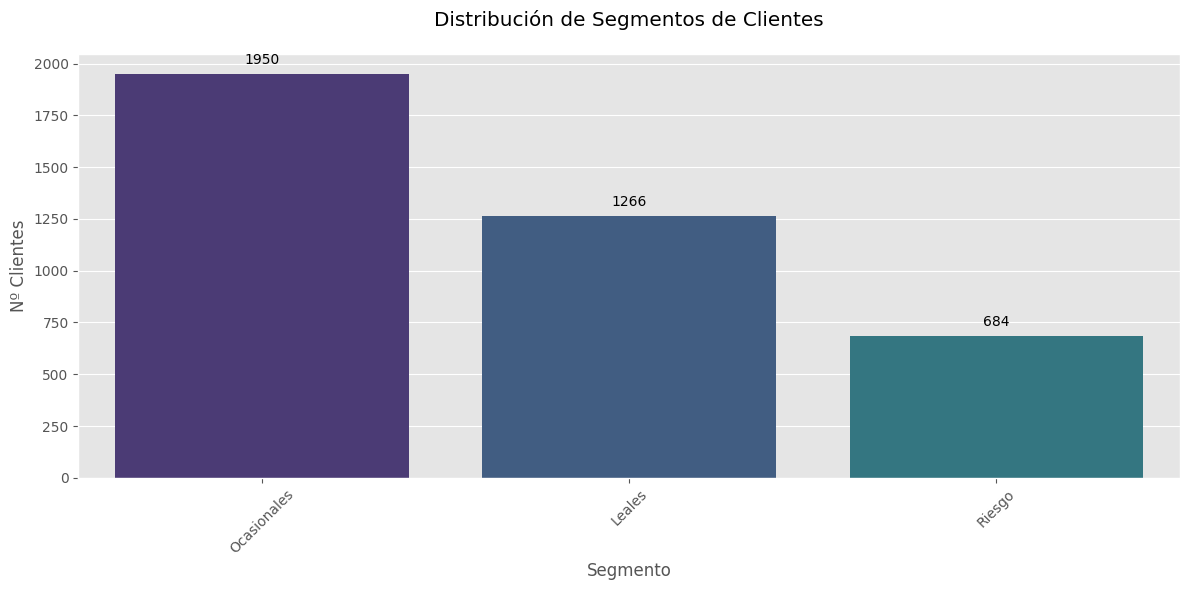

In [93]:
labels = {
    0 : 'Ocasionales',
    1 : 'Leales',
    2 : 'Riesgo'
}

rfm['Segment'] = rfm['Cluster'].map(labels)

plt.figure(figsize=(12, 6))
segment_counts = rfm['Segment'].value_counts().sort_values(ascending=False)
ax = sns.barplot(x=segment_counts.index, y=segment_counts.values, hue=segment_counts.index, legend=False)
plt.title('Distribución de Segmentos de Clientes', pad=20)
plt.xlabel('Segmento')
plt.ylabel('Nº Clientes')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

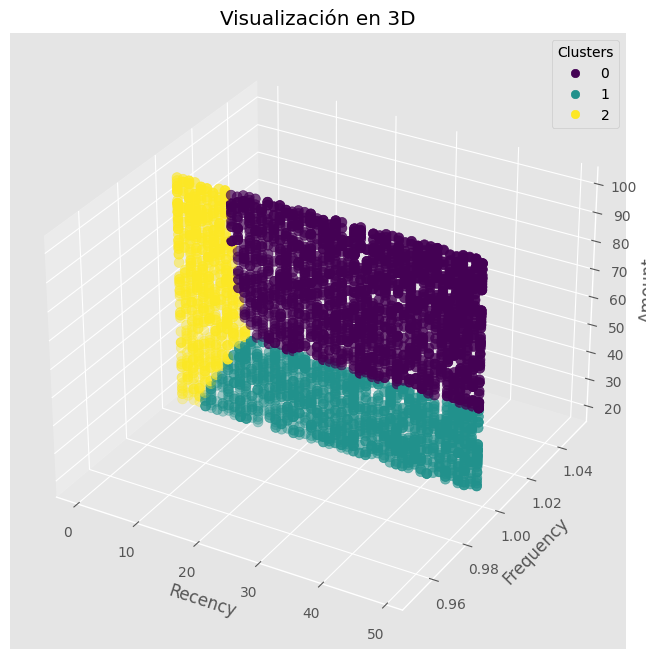

In [94]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Amount'], 
                     c=rfm['Cluster'], cmap='viridis', s=50)

ax.set_title('Visualización en 3D')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Amount')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

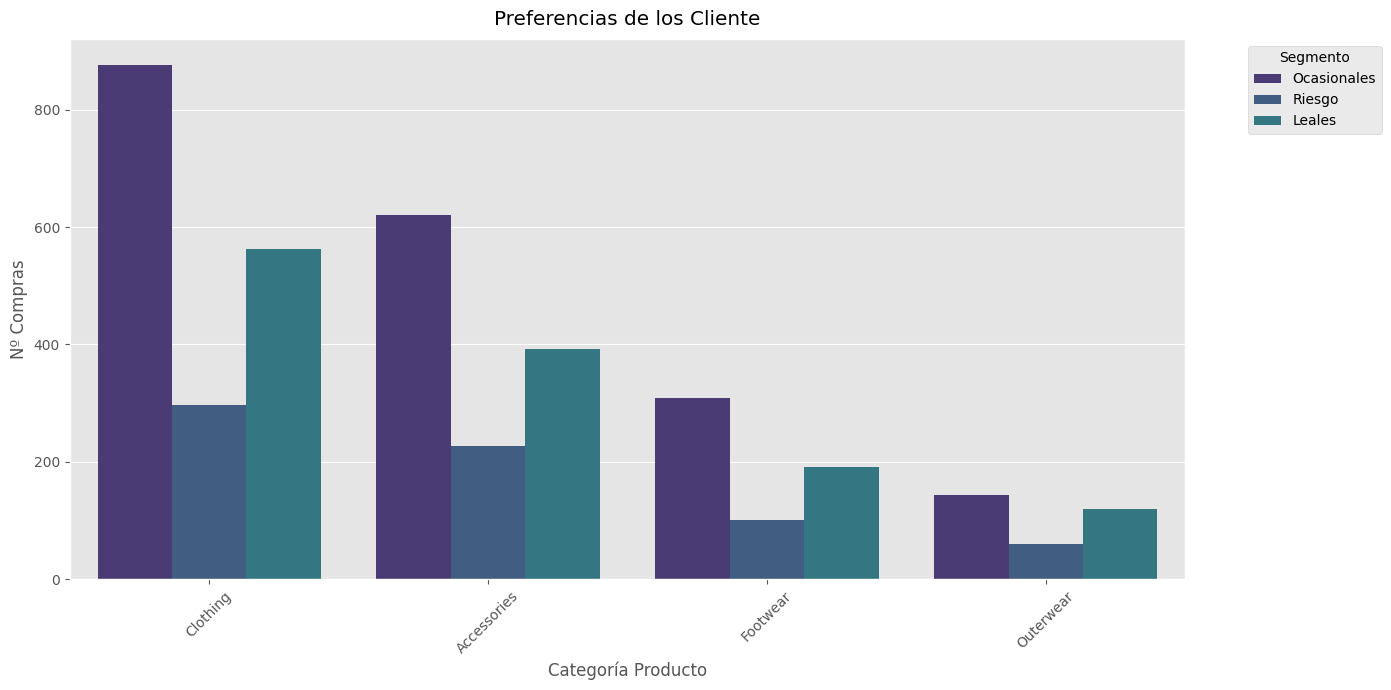

In [96]:
df_segmented = df.merge(rfm[['Customer ID', 'Segment']], on='Customer ID', how='left')

plt.figure(figsize=(14, 7))
sns.countplot(data=df_segmented, x='Category', hue='Segment', 
              order=df_segmented['Category'].value_counts().index)
plt.title('Preferencias de los Cliente', pad=10)
plt.xlabel('Categoría Producto')
plt.ylabel('Nº Compras')
plt.xticks(rotation=45)
plt.legend(title='Segmento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

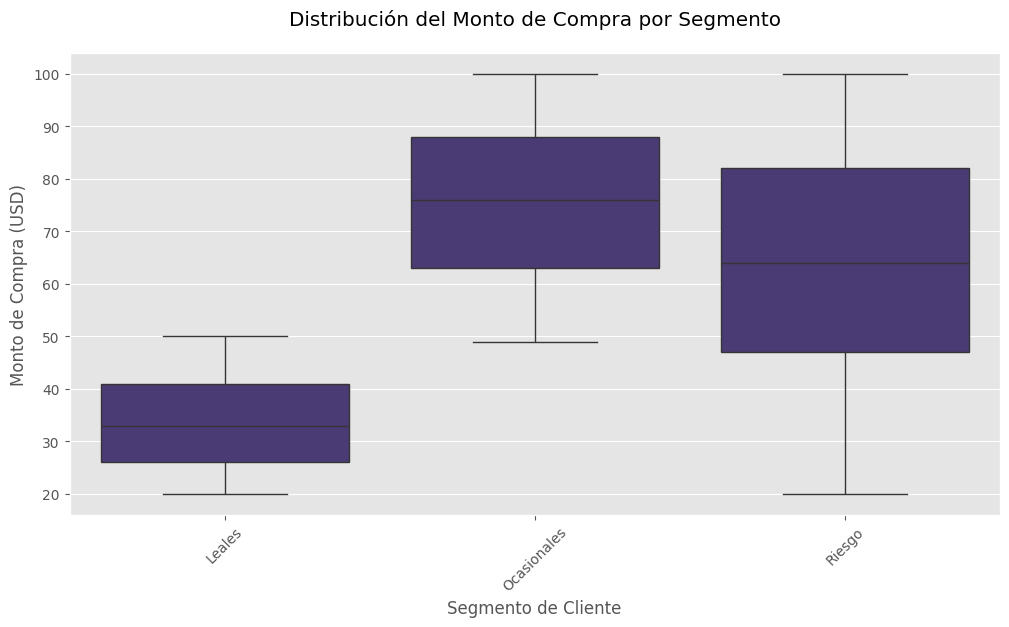

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_segmented, x='Segment', y='Purchase Amount (USD)', 
            order=['Leales', 'Ocasionales', 'Riesgo'])
plt.title('Distribución del Monto de Compra por Segmento', pad=20)
plt.xlabel('Segmento de Cliente')
plt.ylabel('Monto de Compra (USD)')
plt.xticks(rotation=45)
plt.show()

In [98]:
rfm.to_csv('customer_segments.csv', index=False)
df_segmented.to_csv('shopping_trends_segmented.csv', index=False)

print("Guardado completo")

Guardado completo


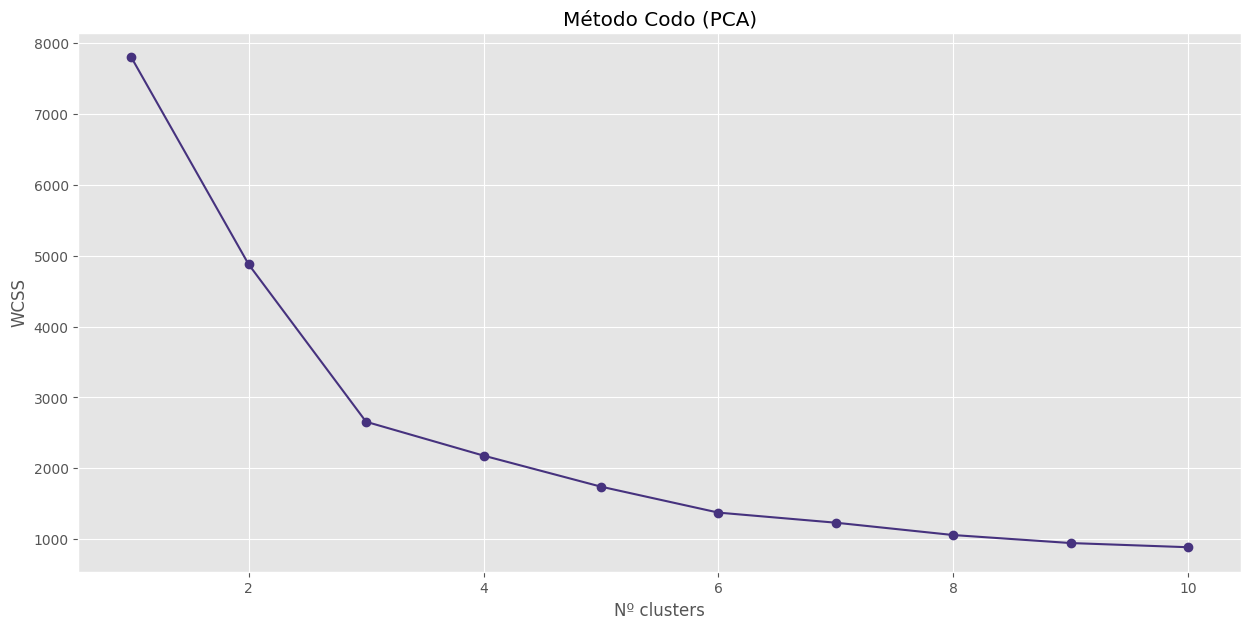

In [99]:
# Ahora trabajaremos con PCA 

pca = PCA(n_components=2)
pca = pca.fit_transform(scaled)

wcssPca = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pca)
    wcssPca.append(kmeans.inertia_)

plt.figure(figsize=(15, 7))
plt.plot(range(1, 11), wcssPca, marker='o')
plt.title('Método Codo (PCA)')
plt.xlabel('Nº clusters')
plt.ylabel('WCSS')
plt.show()

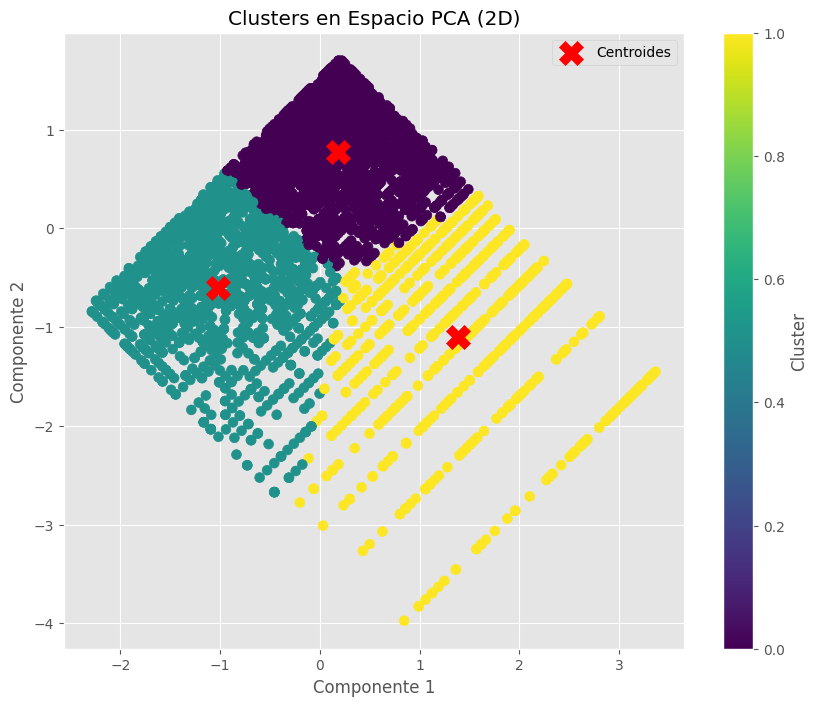

In [100]:

kmeans_pca = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_pca.fit(pca)
rfm['Cluster_PCA'] = kmeans_pca.labels_

plt.figure(figsize=(10, 8))
plt.scatter(pca[:, 0], pca[:, 1], c=rfm['Cluster_PCA'], cmap='viridis', s=50)
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], 
            s=300, c='red', marker='X', label='Centroides')
plt.title('Clusters en Espacio PCA (2D)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend()
plt.colorbar(label='Cluster')
plt.show()

Comparación:
Con PCA      Leales  Ocasionales  Riesgo
Sin PCA                                 
Leales         1266            0       0
Ocasionales       0         1950       0
Riesgo            0            0     684


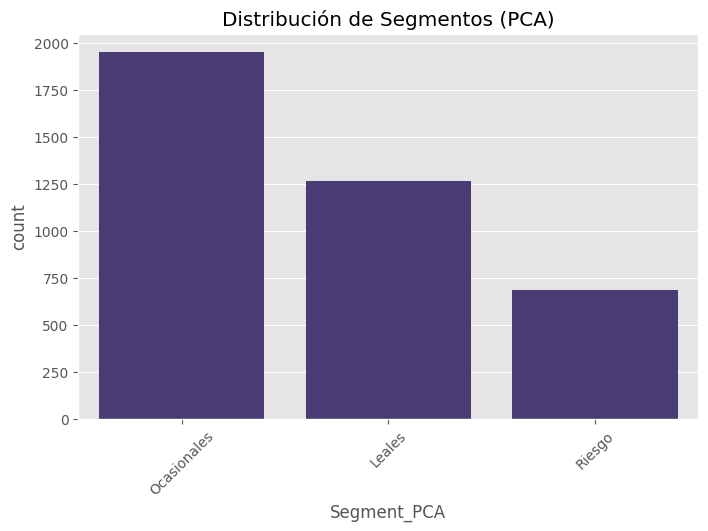

In [101]:
names = labels

rfm['Segment_PCA'] = rfm['Cluster_PCA'].map(names)

comparison = pd.crosstab(rfm['Segment'], rfm['Segment_PCA'], rownames=['Sin PCA'], colnames=['Con PCA'])
print("Comparación:")
print(comparison)

plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x='Segment_PCA', order=names.values())
plt.title('Distribución de Segmentos (PCA)')
plt.xticks(rotation=45)
plt.show()

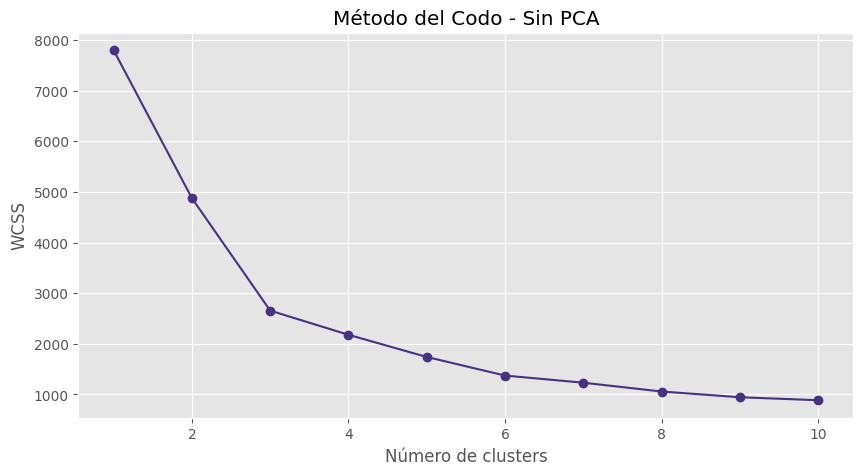

In [108]:
# Ahora sin PCA

df = pd.read_csv('shopping_trends.csv')
rfm = df.groupby('Customer ID').agg({
    'Purchase Amount (USD)': 'sum',
    'Customer ID': 'count',
    'Previous Purchases': 'max'
}).rename(columns={
    'Purchase Amount (USD)': 'Amount',
    'Customer ID': 'Frequency',
    'Previous Purchases': 'Recency'
}).reset_index()

rfm['Recency'] = rfm['Recency'].max() - rfm['Recency']

aux_log = rfm[['Recency', 'Frequency', 'Amount']].apply(np.log1p)

scaler = StandardScaler()
scaled = scaler.fit_transform(aux_log)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo - Sin PCA')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

Estadísticas por Cluster (sin PCA):
           Recency                Frequency                    Amount         \
              mean median min max      mean median min max       mean median   
Cluster                                                                        
0        29.810769   30.0   9  49       1.0    1.0   1   1  75.339487   76.0   
1        27.755134   28.0   4  49       1.0    1.0   1   1  33.590837   33.0   
2         4.181287    4.0   0  11       1.0    1.0   1   1  63.805556   64.0   

                 Count  
        min  max count  
Cluster                 
0        49  100  1950  
1        20   50  1266  
2        20  100   684  


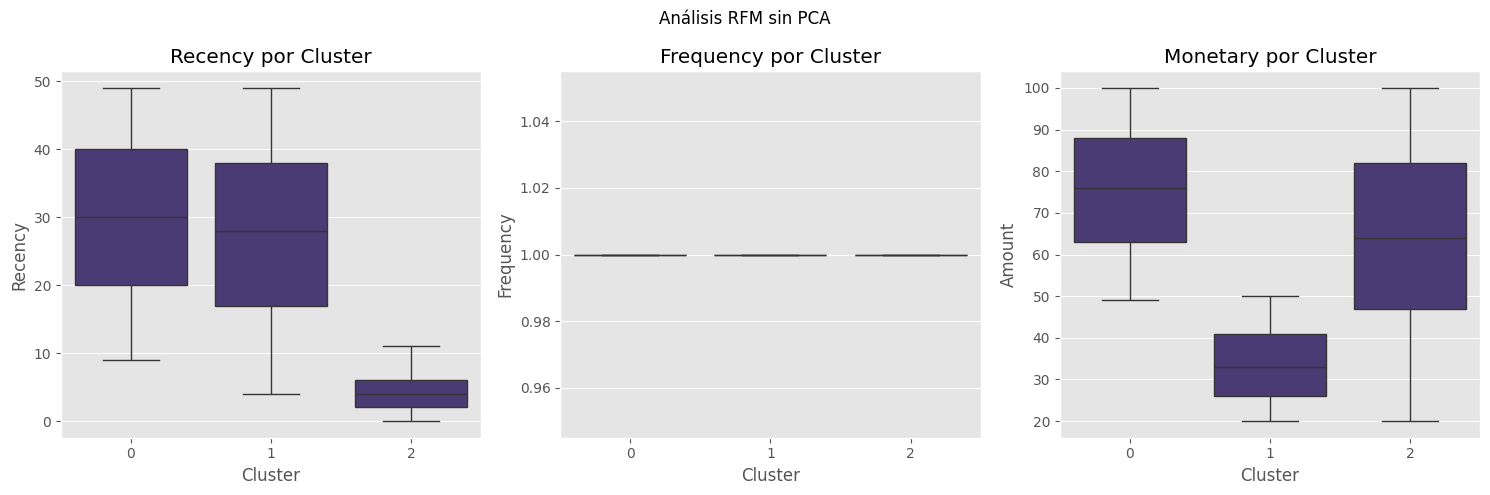

In [109]:

kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(scaled)
rfm['Cluster'] = kmeans.labels_

stats = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'min', 'max'],
    'Frequency': ['mean', 'median', 'min', 'max'],
    'Amount': ['mean', 'median', 'min', 'max'],
    'Customer ID': 'count'
}).rename(columns={'Customer ID': 'Count'})

print("Estadísticas por Cluster (sin PCA):")
print(stats)

plt.figure(figsize=(15, 5))
plt.suptitle('Análisis RFM sin PCA')

plt.subplot(1, 3, 1)
sns.boxplot(data=rfm, x='Cluster', y='Recency')
plt.title('Recency por Cluster')

plt.subplot(1, 3, 2)
sns.boxplot(data=rfm, x='Cluster', y='Frequency')
plt.title('Frequency por Cluster')

plt.subplot(1, 3, 3)
sns.boxplot(data=rfm, x='Cluster', y='Amount')
plt.title('Monetary por Cluster')

plt.tight_layout()
plt.show()

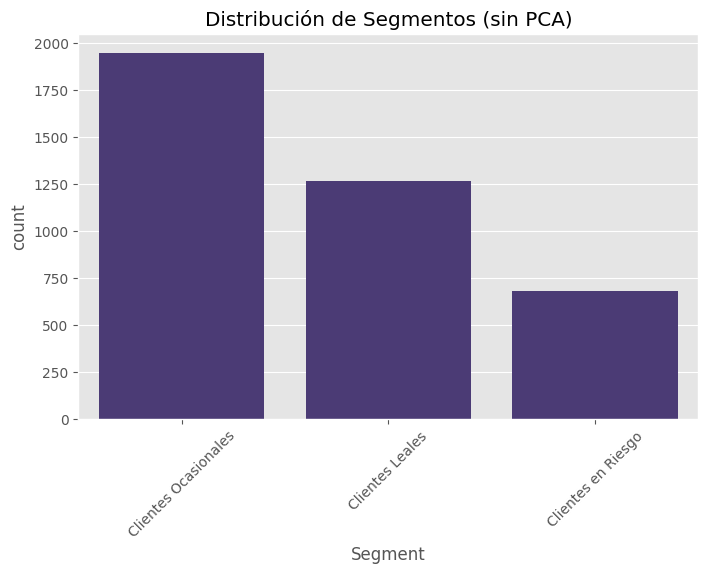

In [ ]:
cluster_names = {
    0: 'Clientes Ocasionales',
    1: 'Clientes Leales',
    2: 'Clientes en Riesgo',
}
rfm['Segment'] = rfm['Cluster'].map(cluster_names)

plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x='Segment', order=cluster_names.values())
plt.title('Distribución de Segmentos (sin PCA)')
plt.xticks(rotation=45)
plt.show()

# Conclusiones:

## Segmentos Identificados:
- **Clientes Leales**: Frecuencia alta de compra, gasto moderado (prioridad de retención).
- **Clientes en Riesgo**: Largo tiempo sin comprar, historial de gasto alto (necesitan reactivación).
- **Clientes Ocasionales**: Representan la mayoría, baja frecuencia de compra (oportunidad de conversión).

## Resultados:
1. **Validación de clusters**:
   - Métodos del codo y silueta confirman que 3 clusters es el número óptimo.
   - Visualización en espacios RFM y PCA muestra buena separación entre grupos.

2. **Distribución de clientes**:
   - Mayoría son clientes ocasionales, seguidos por leales y luego en riesgo.
   - Oportunidad clave para mejorar estrategias de fidelización.

3. **Recomendaciones**:
   - Campañas personalizadas por segmento.
   - Programas de retención para clientes leales.
   - Acciones específicas para reactivar clientes en riesgo.